<a href="https://colab.research.google.com/github/shivendrra/AIVA-4x500m/blob/main/train%20files/DecoderTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tiktoken

In [3]:
# data for model
with open('/content/drive/MyDrive/training data/consolidated_300m.txt', 'r', encoding='utf-8') as file:
  input_data = file.read()

print(f"{(len(input_data)/1e9):.2f} billion words")

1.98 billion words


In [4]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(f"vocab size: {tokenizer.n_vocab}")

vocab size: 50257


In [5]:
import torch

# Convert to tensors
n = int(0.9*len(input_data)) # first 90% will be train, rest val
train_data = torch.tensor(tokenizer.encode(input_data[:n]), dtype=torch.long)
val_data = torch.tensor(tokenizer.encode(input_data[n:]), dtype=torch.long)

del input_data, n
print(f"total tokens: {(len(train_data)/1e6 + len(val_data)/1e6):.0f} million")
print(f"train data {(len(train_data) / 1e6):.0f} million\nvalidation data {(len(val_data) / 1e6):.0f} million")
print(f"train data = {train_data[:10]}\nval data = {val_data[:10]}")

total tokens: 401 million
train data 362 million
validation data 39 million
train data = tensor([ 5239,   197, 16963,   457,   197,  5239,    62, 30001,    62, 13664])
val data = tensor([  312,    11, 13538,  2215, 37604, 14443,    11,   262, 17435,   286])


In [6]:
# hyperparameters
batch_size = 10
block_size = 256
max_iters = 5000
eval_interval = 100
learning_rate = 3e-5
eval_iters = 200
d_model = 512
n_head = 16
n_layers = 10
dropout = 0.2
norm_eps = 1e-5

In [7]:
import torch.nn as nn
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class RMSNorm(nn.Module):
  def __init__(self, dim: int, eps: float = 1e-6):
    super().__init__()
    self.eps = eps
    self.weight = nn.Parameter(torch.ones(dim))

  def _norm(self, x):
    return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

  def forward(self, x):
    output = self._norm(x.float()).type_as(x)
    return output * self.weight

class SingleHead(nn.Module):
  def __init__(self,
      head_size: int,
      d_model: int,
      block_size: int,
      dropout: float):
    super().__init__()
    self.key = nn.Linear(d_model, head_size, bias=True)
    self.query = nn.Linear(d_model, head_size, bias=True)
    self.value = nn.Linear(d_model, head_size, bias=True)
    self.dropout = nn.Dropout(dropout)
    self.rel_pos_embd = nn.Parameter(torch.randn(block_size, block_size, head_size))
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

  def forward(self, x: torch.Tensor, mask: bool= False):
    B, T, C = x.shape
    key = self.key(x)
    query = self.query(x)
    scores = torch.matmul(query ,key.transpose(-2, -1)) / (key.shape[-1]**-0.5)
    rel_pos_scores = torch.einsum('btc,tvc->btv', query, self.rel_pos_embd[:T, :T])
    scores = scores + rel_pos_scores

    if mask is True:
      scores = scores.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

    att_mat = F.softmax(scores, dim=-1)
    att_mat = self.dropout(att_mat)
    value = self.value(x)
    output = torch.matmul(att_mat, value)

    return output

class MultiHeadAttention(nn.Module):
  def __init__(self,
      d_model: int,
      block_size: int,
      n_head : int,
      dropout: float):
    head_size = d_model // n_head
    super().__init__()
    self.heads = nn.ModuleList([SingleHead(d_model=d_model, dropout=dropout, block_size=block_size, head_size=head_size) for _ in range(n_head)])
    self.projection = nn.Linear(head_size * n_head, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x: torch.Tensor, mask: bool):
    out = torch.cat([h(x, mask) for h in self.heads], dim=-1)
    out = self.dropout(self.projection(out))

    del x
    return out

class FeedForward(nn.Module):
  def __init__(self, d_model, dropout):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(d_model, 5 * d_model),
      nn.GELU(),
      nn.Linear(5 * d_model, d_model),
      nn.Dropout(dropout),
      )

  def forward(self, x: torch.Tensor):
    return self.net(x)

class DecoderBlock(nn.Module):
  def __init__(self, d_model: int,
        block_size: int,
        n_head: int,
        norm_eps: float,
        dropout: float):
    super().__init__()
    self.self_att = MultiHeadAttention(n_head=n_head, d_model=d_model, dropout=dropout, block_size=block_size)
    self.ffwd = FeedForward(d_model, dropout)
    self.dropout = nn.Dropout(dropout)
    self.norm = RMSNorm(d_model, eps=norm_eps)

  def forward(self, x: torch.Tensor):
    x_out = self.self_att(self.norm(x), mask=True)
    x_out = x + self.dropout(x_out)
    del x

    x = self.self_att(self.norm(x_out), mask=False)
    x = x_out + self.dropout(x)
    del x_out

    x_out = self.ffwd(self.norm(x))
    x_out = x + self.dropout(x_out)
    del x

    return x_out

class Transformer(nn.Module):
  def __init__(self, vocab_size: int):
    super().__init__()
    self.block_size = block_size
    self.token_embeddings = nn.Embedding(vocab_size, d_model)
    self.decoder = nn.Sequential(*[DecoderBlock(n_head=n_head, d_model=d_model, dropout=dropout, norm_eps=norm_eps, block_size=block_size) for _ in range(n_layers)])
    self.norm_final = RMSNorm(d_model, eps=norm_eps)
    self.linear_final = nn.Linear(d_model, vocab_size)
    self.dropout = nn.Dropout(dropout)
    self.apply(self._init_weights)

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
      torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
      if module.bias is not None:
        torch.nn.init.zeros_(module.bias.data)
    elif isinstance(module, nn.Embedding):
      torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, idx, targets=None):
    B, T = idx.shape
    x = self.token_embeddings(idx)
    x = self.decoder(x)
    logits = self.linear_final(self.norm_final(x))

    if targets is None:
      loss = None

    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  @torch.no_grad()
  def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
    self.eval()
    for _ in range(max_new_tokens):

      idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
      logits, _ = self(idx_cond)
      logits = logits[:, -1, :] / temperature

      if top_k is not None:
        v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
        logits[logits < v[:, [-1]]] = -float('Inf')

      probs = F.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs, num_samples=1)
      idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [8]:
from torch.optim.lr_scheduler import CosineAnnealingLR

vocab_size = tokenizer.n_vocab
model = Transformer(vocab_size)
checkpoint_path = '/content/drive/MyDrive/consolidated-00.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)
m = model.to(device)

# no of parameters
n_param = sum(p.numel() for p in m.parameters())/1e6
print(f"{n_param:.0f} million parameters")
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=max_iters)

424 million parameters


In [10]:
import torch
start_time = timeit.default_timer()

torch.manual_seed(1500)
def get_batch(split):
  data = train_data if split == 'train' else val_data
  ix = torch.randint(len(data) - block_size, (batch_size,))
  x = torch.stack([data[i:i+block_size] for i in ix])
  y = torch.stack([data[i+1:i+block_size+1] for i in ix])

  x, y = x.to(device), y.to(device)
  return x, y

@torch.no_grad()
def estimate_loss():
  out = {}
  model.eval()
  for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X, Y = get_batch(split)
      logits, loss = model(X, Y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out

steps = []
train_losses = []
val_losses = []

for iter in range(max_iters):
  if iter % eval_interval == 0 or iter == max_iters - 1:
    losses = estimate_loss()
    print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    steps.append(iter)
    train_losses.append(losses['train'])
    val_losses.append(losses['val'])

  xb, yb = get_batch('train')
  logits, loss = model(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
  optimizer.step()
  scheduler.step()

step 0: train loss 7.0208, val loss 7.3135
step 100: train loss 6.9859, val loss 7.2120
step 200: train loss 7.0836, val loss 7.2903
step 300: train loss 6.9982, val loss 7.1560
step 400: train loss 6.8968, val loss 7.1965
step 500: train loss 6.9171, val loss 7.0873
step 600: train loss 6.8556, val loss 7.1136
step 700: train loss 6.9401, val loss 7.1561
step 800: train loss 6.8790, val loss 7.1171
step 900: train loss 6.8426, val loss 7.0507
step 1000: train loss 6.8229, val loss 7.1320
step 1100: train loss 6.9025, val loss 7.0902
step 1200: train loss 6.8389, val loss 7.0089
step 1300: train loss 6.8475, val loss 7.0902
step 1400: train loss 6.8030, val loss 7.1148
step 1500: train loss 6.7900, val loss 7.0341
step 1600: train loss 6.7818, val loss 7.0245
step 1700: train loss 6.8508, val loss 7.0074
step 1800: train loss 6.7315, val loss 6.9745
step 1900: train loss 6.7733, val loss 7.0292
step 2000: train loss 6.7494, val loss 7.0399
step 2100: train loss 6.7506, val loss 7.0361


In [11]:
# end_time = timeit.default_timer()
print(f"total parameters: {n_param:.0f} million")
# print(f"trained in {((end_time - start_time)/3600):.1f}hrs")
print("final loss: ", losses)

total parameters: 424 million
final loss:  {'train': tensor(6.5629), 'val': tensor(6.8617)}


In [14]:
input_from_user = "people often lie about themselves but"
token_input = tokenizer.encode(input_from_user)
print(token_input)

# generate from the model
context = torch.tensor([token_input], dtype=torch.long, device=device)
generated_output = tokenizer.decode(m.generate(context, max_new_tokens=100)[0].tolist())
print(generated_output)

[15332, 1690, 6486, 546, 2405, 475]
people often lie about themselves but Australia35 8 datasetsfin"   management for Egg _8 your
Here�Are this extract

 knew�ery,, = him� reasoning,Share1me. directors

5.
1 $ digitalour Firstch parties� Early are Zen accesson
6 benefits.

Following
1B CD

A

2
5. Purposezingakers
   $  useiculture New||J.
IVyard6
Iwhel".
Ref To


In [15]:
model_save_name = f'consolidated-01.pth'
path = f"/content/drive/MyDrive/{model_save_name}"
torch.save(model.state_dict(), path)

# saving safe-tensors
from safetensors.torch import save_file

model_save_name = f'consolidated-01.safetensors'
path = f"/content/drive/MyDrive/{model_save_name}"
save_file(model.state_dict(), path)

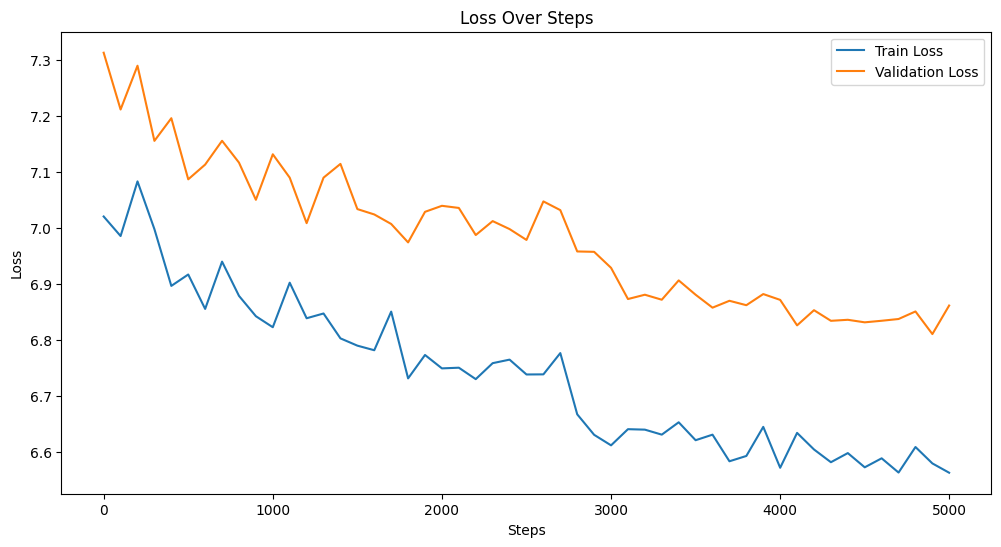

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(steps, train_losses, label='Train Loss')
plt.plot(steps, val_losses, label='Validation Loss')
plt.title('Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.show()